In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [2]:
if (torch.cuda.is_available()):
  device = torch.device("cuda")
  print(device, torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print(device)

cuda Tesla T4


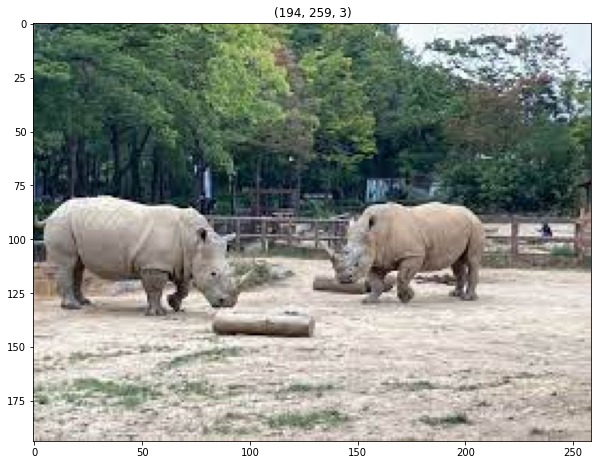

In [3]:
img = cv2.imread('/content/zoo.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.title(img.shape)
plt.show()

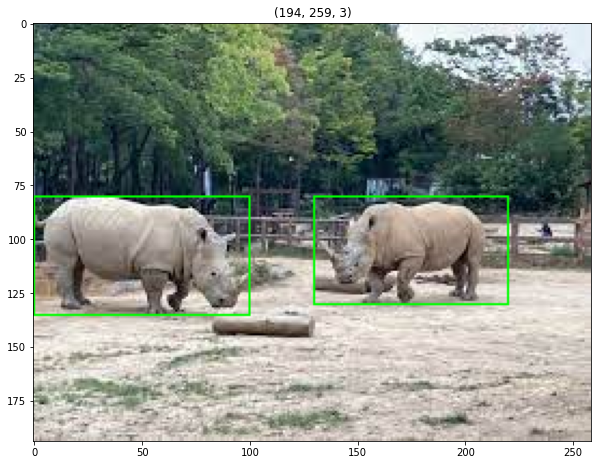

In [4]:
boxes = np.array([[0, 80, 100, 135], [130, 80, 220, 130]])
copy_img = img.copy()

for box in boxes:
  cv2.rectangle(copy_img, (box[0],box[1]), (box[2],box[3]), color=(0,255,0), thickness=1)

plt.figure(figsize=(10,10))
plt.imshow(copy_img)
plt.title(copy_img.shape)
plt.show()

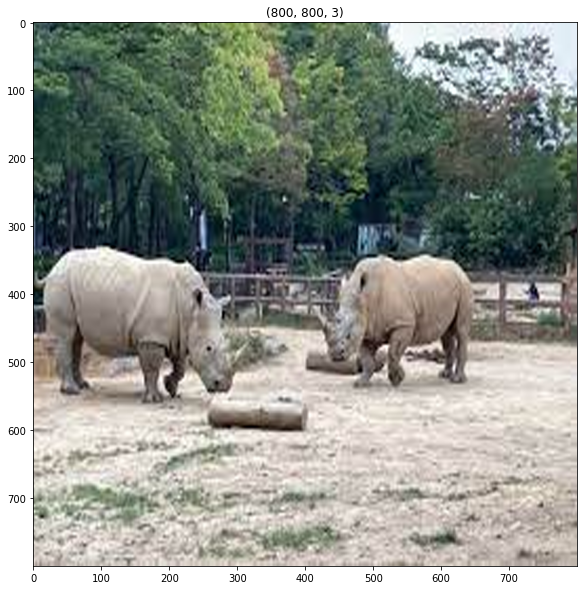

In [5]:
# Resize Image & Bounding box
draw_img = cv2.resize(img, dsize=(800,800), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(10,10))
plt.imshow(draw_img)
plt.title(draw_img.shape)
plt.show()

In [6]:
width_rartio = 800/img.shape[1]
height_ration = 800/img.shape[0]

print("width_rartio: {}\nheight_ration: {}".format(width_rartio, height_ration))

bound_boxes = []
for box in boxes:
  x1 = int(box[0]*width_rartio)
  y1 = int(box[1]*height_ration)
  x2 = int(box[2]*width_rartio)
  y2 = int(box[3]*height_ration)
  bound_boxes.append([x1, y1, x2, y2])
print(bound_boxes)

width_rartio: 3.088803088803089
height_ration: 4.123711340206185
[[0, 329, 308, 556], [401, 329, 679, 536]]


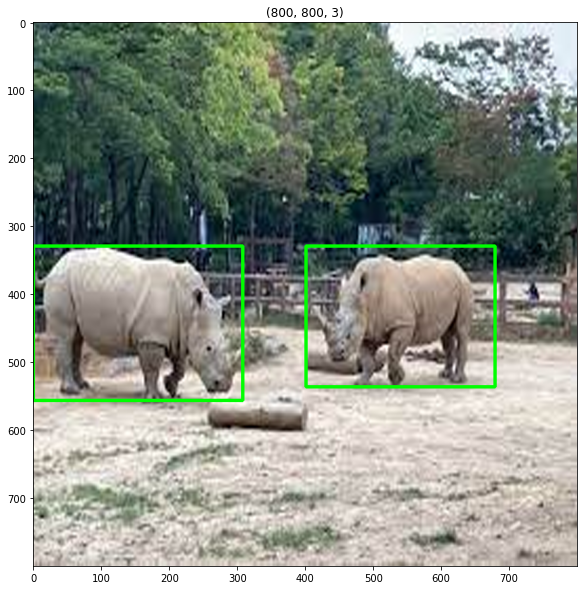

In [7]:
image = draw_img.copy()

for box in bound_boxes:
  cv2.rectangle(image, (box[0],box[1]), (box[2],box[3]), color=(0,255,0), thickness=3)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.title(image.shape)
plt.show()

### Load Pre trained model "VGG16"

In [8]:
model = torchvision.models.vgg16(pretrained=True).to(device)
features = list(model.features)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [9]:
## 원본 모델 layers
for feature in features:
  print(feature)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True

In [10]:
dummy_img = torch.zeros((1,3,800,800)).float()
print("Dummy img shape: {}".format(dummy_img.shape))

req_features = []
output = dummy_img.clone().to(device)

for feature in features:
  output = feature(output)

  # 원본이미지의 크기가 50*50이 될때까지만 feature extractor로 사용함
  if output.size()[2] < 800//16:
    break
  req_features.append(feature)
  out_channels = output.size()[1]

faster_rcnn_feature_extractor = nn.Sequential(*req_features)

Dummy img shape: torch.Size([1, 3, 800, 800])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Test model with test data and plot feature maps

In [11]:
# 테스트이미지를 모델에 넣어 feature extractor를 해본다

transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(image).to(device)
imgTensor = imgTensor.unsqueeze(0)

output_map = faster_rcnn_feature_extractor(imgTensor)
print("Output size : {}".format(output_map.shape))

Output size : torch.Size([1, 512, 50, 50])


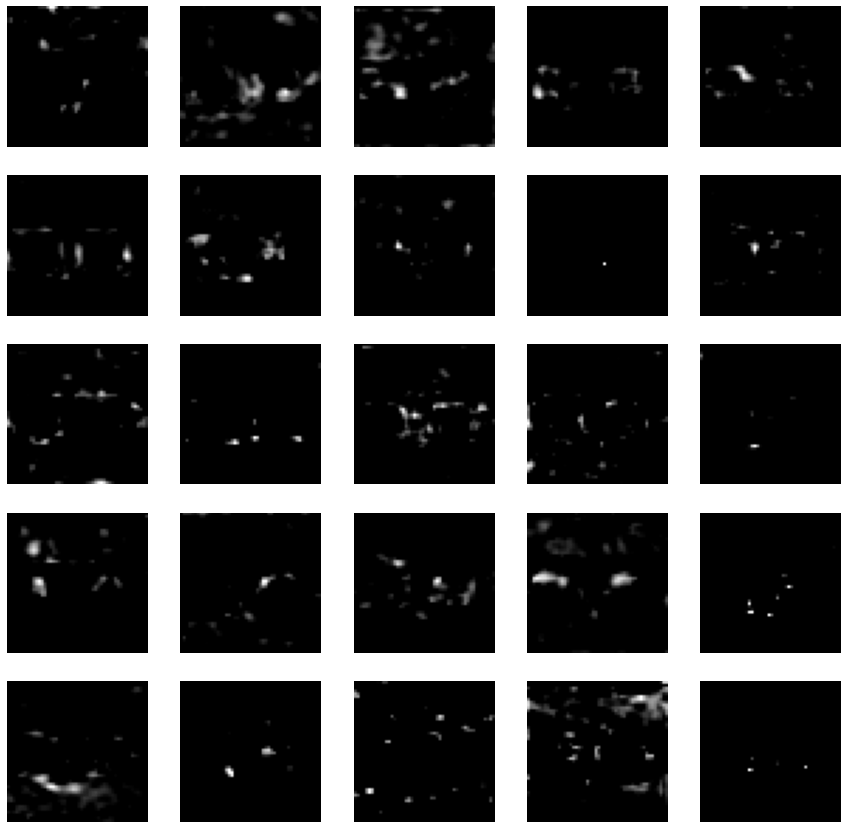

In [12]:
# feature map을 시각화

# Batch shape를 잠시 제거
img_array = output_map.data.cpu().numpy().squeeze(0)

fig , axes = plt.subplots(5, 5, figsize=(15,15))

x_idx = 0
y_idx = 0

for i in range(5*5):
    if x_idx == 5:
        x_idx = 0
        y_idx += 1
        
    axes[y_idx][x_idx].imshow(img_array[i], 'gray')
    axes[y_idx][x_idx].axis("off")
    x_idx += 1

plt.show()

#### Anchor 생성
#### 50 * 50 = 2500 앵커

In [13]:
feature_size = 800//16
print("Feature maps size : {}".format(feature_size))
center_x = np.arange(16,(feature_size+1)*16, 16)
center_y = np.arange(16,(feature_size+1)*16, 16)
print(len(center_x))
print(center_x)

Feature maps size : 50
50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [14]:
index = 0
center = np.zeros((2500,2))

for i in range(len(center_x)):
  for j in range(len(center_y)):
    center[index, 0] = center_x[i] - 8
    center[index, 1] = center_y[j] - 8
    index += 1
print("Center Shape: {}".format(center.shape))
print(center[:10])

Center Shape: (2500, 2)
[[  8.   8.]
 [  8.  24.]
 [  8.  40.]
 [  8.  56.]
 [  8.  72.]
 [  8.  88.]
 [  8. 104.]
 [  8. 120.]
 [  8. 136.]
 [  8. 152.]]


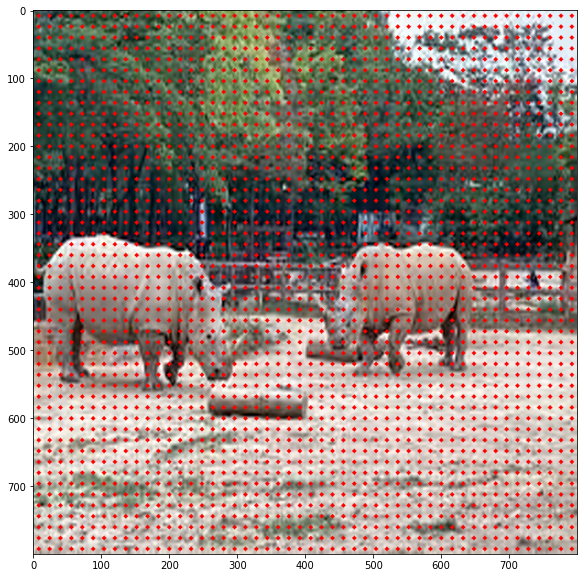

In [15]:
img_copy2 = np.copy(draw_img)
center_int = center.astype("int32")

plt.figure(figsize=(10,10))
for o in center_int:
  cv2.circle(img_copy2, (o[0],o[1]), radius=1,
             color=(255,0,0), thickness=3)

plt.imshow(img_copy2)
plt.show()

#### Anchor Box 생성
#### 50 * 50 = 2500 앵커박스 * 9개의 모양 = 22500 개의 앵커 박스

In [16]:
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
feature_size = 800 // 16

anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4))
index = 0

for c in center:
  sam_center_x, sam_center_y = c
  for ratio in ratios:
    for scale in scales:

      h = sub_sample * scale * np.sqrt(ratio)
      w = sub_sample * scale * np.sqrt(1./ratio)

      anchor_boxes [index, 0] = sam_center_x - w/2.
      anchor_boxes [index, 1] = sam_center_y - h/2.
      anchor_boxes [index, 2] = sam_center_x + w/2.
      anchor_boxes [index, 3] = sam_center_y + h/2.
      index +=1

print(anchor_boxes.shape)
print(anchor_boxes[:10, :])

(22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 [ -56.          -56.           72.           72.        ]
 [-120.         -120.          136.          136.        ]
 [-248.         -248.          264.          264.        ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -82.50966799  -21.254834     98.50966799   69.254834  ]]


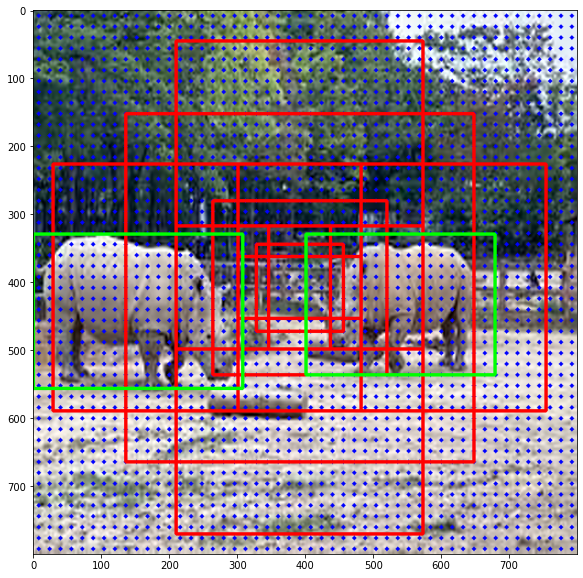

In [17]:
img_copy2 = np.copy(draw_img)
center_int = center.astype("int32")

plt.figure(figsize=(10,10))

for o in center_int:
  cv2.circle(img_copy2, (o[0],o[1]), radius=1,
             color=(0,0,255), thickness=3)

# draw random anchor boxes
for i in range(11025, 11034):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    cv2.rectangle(img_copy2, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)
    
for box in bound_boxes:
  cv2.rectangle(img_copy2, (box[0],box[1]), (box[2],box[3]), color=(0,255,0), thickness=3)

plt.imshow(img_copy2)
plt.show()

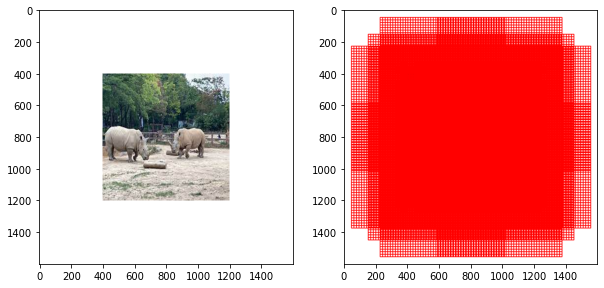

In [18]:
## 모든 Anchor box들 출력
## 이미지 사이즈보다 큰 Anchor box를 그릴 수 없기떄문에 padding을 추가해줌
img_copy3 = np.copy(draw_img)
img_copy4 = cv2.copyMakeBorder(img_copy3, 400, 400, 400, 400,
                               cv2.BORDER_CONSTANT, value=(255,255,255))
img_copy5 = np.copy(img_copy4)

for anchor in anchor_boxes:
  x1 = int(anchor[0])
  y1 = int(anchor[1])
  x2 = int(anchor[2])
  y2 = int(anchor[3])

  cv2.rectangle(img_copy5, (x1+400, y1+400), (x2+400, y2+400), color=(255,0,0), thickness=3)

fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(img_copy4)
axes[1].imshow(img_copy5)
plt.show()

### Target 값에 속하는 Anchor box 시각화

In [19]:
# 이미지 안에 속해있는 Anchor box들의 인덱스를 추출

index_inside = np.where(
    (anchor_boxes[:, 0] >=0) &
    (anchor_boxes[:, 1] >=0) &
    (anchor_boxes[:, 2] <=800) &
    (anchor_boxes[:, 3] <=800))[0]

print(index_inside.shape)
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


In [20]:
ious = np.empty((len(valid_anchor_boxes),2), dtype=np.float32)
ious.fill(0)

# anchor boxes
for i, anchor_box in enumerate(valid_anchor_boxes):
    xa1, ya1, xa2, ya2 = anchor_box
    anchor_area = (xa2 - xa1) * (ya2 - ya1)
    
    # ground truth boxes
    for j, gt_box in enumerate(bound_boxes):
        xb1, yb1, xb2, yb2 = gt_box
        box_area = (xb2 - xb1) * (yb2 - yb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0
        
        ious[i, j] = iou
        
print(ious.shape)
print(ious[8930:8940, :])

(8940, 2)
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [21]:
# Neg / Pos 구별
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[ 607 6620]
[0.7513835 0.7560565]
[ 607  612  793  798  979  984 6620 6628 6636 6643]


In [22]:
argmax_ious = ious.argmax(axis=1)
print("argmax_ious shape : ", argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print("max_ious shape : ", max_ious.shape)
print(max_ious)

argmax_ious shape :  (8940,)
[0 0 0 ... 0 0 0]
max_ious shape :  (8940,)
[0. 0. 0. ... 0. 0. 0.]


In [23]:
label = np.zeros_like(index_inside)
label.fill(-1)
print(label.shape)
print(label[:10])

(8940,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [24]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0
print(label[:10])

[0 0 0 0 0 0 0 0 0 0]


In [25]:
# 매번 배치적으로 학습을 한다 256개의 vaild anchor box와 함께
n_samples = 256

# postive data sampling
pos_ratio = 0.5
n_pos = pos_ratio * n_samples

pos_index = np.where(label == 1)
if len(pos_index) > n_pos:
  disable_index = np.random.choice(pos_index,
                                  size=(len(pos_index) - n_pos),
                                  replace=False)
  label[disable_index] = -1

# negative data sampling
neg_ratio = 0.5
n_neg = n_samples * np.sum(label == 1)

neg_index = np.where(label == 0)
if len(neg_index) > n_pos:
  disable_index = np.random.choice(pos_index,
                                  size=(len(neg_index) - n_pos),
                                  replace=False)
  label[disable_index] = -1

In [26]:
len(label)

8940

In [27]:
print("Label 1 :{} \n Label 2: {}".format(np.where(label==1), np.where(label==0)))

Label 1 :(array([ 602,  607,  612,  788,  793,  798,  974,  979,  984, 1184, 1191,
       1197, 6374, 6382, 6390, 6397, 6620, 6628, 6636, 6643, 6857, 6864,
       6871, 6877]),) 
 Label 2: (array([   0,    1,    2, ..., 8937, 8938, 8939]),)


In [29]:
# 바운딩 박스 회귀
max_iou_bbox = np.array([bound_boxes[argmax_iou] for argmax_iou in argmax_ious])
print("valid_anchor_boxes len : {}".format(valid_anchor_boxes.shape))
print(valid_anchor_boxes[:5])
print("max_iou_bbox len : {}".format(max_iou_bbox.shape))
print(max_iou_bbox[:5])
# 원본이미지 내의 앵커박스들
height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
center_x = valid_anchor_boxes[:, 0] + 0.5*width
center_y = valid_anchor_boxes[:, 1] + 0.5*height

# 가장 큰 iou를 갖는 것들의 label을 정한 것들의 앵커박스
base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_center_x = max_iou_bbox[:, 0] + 0.5 * base_width
base_center_y = max_iou_bbox[:, 1] + 0.5 * base_height

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dx = (base_center_x - center_x) / width
dy = (base_center_y - center_y) / height
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print("anchor_locs: {}".format(anchor_locs.shape))
print(anchor_locs[:5])

valid_anchor_boxes len : (8940, 4)
[[ 10.745166    13.49033201 101.254834   194.50966799]
 [ 10.745166    29.49033201 101.254834   210.50966799]
 [ 10.745166    45.49033201 101.254834   226.50966799]
 [ 10.745166    61.49033201 101.254834   242.50966799]
 [ 10.745166    77.49033201 101.254834   258.50966799]]
max_iou_bbox len : (8940, 4)
[[  0 329 308 556]
 [  0 329 308 556]
 [  0 329 308 556]
 [  0 329 308 556]
 [  0 329 308 556]]
anchor_locs: (8940, 4)
[[1.08275726 1.86996598 1.22464311 0.22634616]
 [1.08275726 1.78157763 1.22464311 0.22634616]
 [1.08275726 1.69318928 1.22464311 0.22634616]
 [1.08275726 1.60480094 1.22464311 0.22634616]
 [1.08275726 1.51641259 1.22464311 0.22634616]]


In [30]:
print("valid_anchor_boxes shape :", valid_anchor_boxes.shape)
valid_anchor_boxes[:10]

valid_anchor_boxes shape : (8940, 4)


array([[ 10.745166  ,  13.49033201, 101.254834  , 194.50966799],
       [ 10.745166  ,  29.49033201, 101.254834  , 210.50966799],
       [ 10.745166  ,  45.49033201, 101.254834  , 226.50966799],
       [ 10.745166  ,  61.49033201, 101.254834  , 242.50966799],
       [ 10.745166  ,  77.49033201, 101.254834  , 258.50966799],
       [ 10.745166  ,  93.49033201, 101.254834  , 274.50966799],
       [ 10.745166  , 109.49033201, 101.254834  , 290.50966799],
       [ 10.745166  , 125.49033201, 101.254834  , 306.50966799],
       [ 10.745166  , 141.49033201, 101.254834  , 322.50966799],
       [ 10.745166  , 157.49033201, 101.254834  , 338.50966799]])

In [31]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)
print(anchor_labels[:10])


anchor_locations = np.zeros_like(anchor_boxes, dtype=anchor_locs.dtype)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)
print(anchor_locations[:10])

(22500,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### RPN
#### 1) Defind RPN

In [32]:
in_channel = 512
mid_channel = 512
n_anchors = 9

In [33]:
conv1 = nn.Conv2d(in_channel, mid_channel, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [36]:
# Bounding Box Regressor
reg_layer = nn.Conv2d(mid_channel, n_anchors*4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [37]:
# Classification (Object or Not)
cls_layer = nn.Conv2d(mid_channel, n_anchors*2, 1, 1, 0).to(device)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

#### 2) Classification and Bounding box regression

In [38]:
x = conv1(output_map.to(device))
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [39]:
# RPN에서 예측한 위치값과 분류를 앵커박스로 변환
# Position: [1, 36(9*4), 50, 50] => [1, 22500(50*50*9), 4] (dy, dx, dh, dw) 
# Classification: [1, 18(9*2), 50, 50] => [1, 22500, 2] (1, 0)

# contiguous = permute는 메모리를 할당하지 않아서 contiguous함수를 통해 메모리 할당
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1,-1,4)
print("pred_anchor_locs shape :",pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print("pred_cls_scores shape :", pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print("pred_cls_scores shape :",objectness_score.shape)

pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print("pred_cls_scores shape :",pred_cls_scores.shape)


pred_anchor_locs shape : torch.Size([1, 22500, 4])
pred_cls_scores shape : torch.Size([1, 50, 50, 18])
pred_cls_scores shape : torch.Size([1, 22500])
pred_cls_scores shape : torch.Size([1, 22500, 2])


In [40]:
# According to the 22500 ROIs predicted by RPN and 22500 anchor boxes, 
# calculate the RPN loss¶

print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [42]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape)
print(rpn_score.shape)
print(gt_rpn_loc.shape)
print(gt_rpn_score.shape)

torch.Size([22500, 4])
torch.Size([22500, 2])
torch.Size([22500, 4])
torch.Size([22500])


#### 3) Multi-task loss

In [43]:
# Get Classification Loss
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device), ignore_index=-1)

print(rpn_cls_loss)

tensor(0.6978, device='cuda:0', grad_fn=<NllLossBackward>)


In [70]:
# Only Postive sample
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc) #rpn_loc만큼 사이즈를 키워줌

mask_loc_preds = rpn_loc[mask].view(-1,4)
mask_loc_targets = gt_rpn_loc[mask].view(-1,4)
print("mask_loc_preds shape : {}\nmask_loc_targets shape: {}".format(mask_loc_preds.shape, mask_loc_targets.shape))


mask_loc_preds shape : torch.Size([24, 4])
 mask_loc_targets shape: torch.Size([24, 4])


In [71]:
x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(rpn_loc_loss.sum())

tensor(0.7502, dtype=torch.float64, grad_fn=<SumBackward0>)


In [72]:
# Combining both the rpn_cls_loss and rpn_reg_loss

rpn_lambda = 10
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(1.0103, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


### Proposal Layer